## Data analysis code for gain=5000 data taken on 08/07/2025. Binning 1x1
Used for scanning frequency on solid target. 

In [12]:
import numpy as np  
import matplotlib.pyplot as plt
import re
import os
from scipy import optimize
from scipy.ndimage import gaussian_filter
import h5py
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.signal import butter, sosfiltfilt, sosfreqz
from scipy import stats

## Define functions for Gaussian fitting

In [2]:
def gaussian(p,x):
    return p[0]/(p[1]*(2*np.pi)**.5)*np.exp(-.5*(x-p[2])**2/(p[1]**2))

#p[0]=multiplicative const
#p[1]=std
#p[2]=mean

def residual(p,x,y,dy):
    return (gaussian(p,x)-y)/dy

In [3]:
def gaussian_fit(counts,probability,probability_uncertainty,p0,plotting_values,show_details):
    ## Implement Gaussian fit
    index_Start, index_End, Plotfit_min, Plotfit_max, Dataplot_min, Dataplot_max = plotting_values
    counts_for_gaussian=counts[index_Start:index_End]
    probability_for_gaussian=probability[index_Start:index_End]
    probability_uncertainty_for_gaussian=probability_uncertainty[index_Start:index_End]
    pf, cov, info, mesg, success = optimize.leastsq(residual, p0, args = (counts_for_gaussian, probability_for_gaussian, 
                                                                          probability_uncertainty_for_gaussian), full_output=1, maxfev=5000)
    ## Plot data and fit
    if cov is None:
        print('fit region: AD count = ', min(counts_for_gaussian), 'to ', max(counts_for_gaussian))
        print('Fit did not converge')
        print('Success code:', success)
        print(mesg)
        fig = plt.figure(figsize=(8,5))
        ax = fig.add_subplot(111)
        ax.errorbar(counts, probability, probability_uncertainty, fmt='k.', label = 'Data',alpha=0.5) 
            #In DarkFrameHistogramFit_polished.ipynb this plots only in the fitted range counts_for_gaussian, but this shouldn't matter if we plot it over all data points.
        x = np.linspace(Plotfit_min,Plotfit_max,1000)
        ax.plot(x, gaussian(p0, x), 'b-', label = 'Guess')
        ax.legend()
        ax.set_title('Gaussian Fit')
        ax.set_xlabel('AD count')
        ax.set_ylabel('Probability')
        ax.set_yscale('log')
        ax.set_xlim([Dataplot_min,Dataplot_max])
        ax.grid()
        plt.show()
    else:
        pferr = [np.sqrt(cov[i,i]) for i in range(len(pf))]
        if show_details:
            print('fit region: AD count = ', min(counts_for_gaussian), 'to ', max(counts_for_gaussian))
            print('Fit Converged')
            chisq = sum(info['fvec']*info['fvec'])
            dof = abs(len(counts_for_gaussian)-len(pf))
            print('Converged with chi-squared', chisq)
            print('Number of degrees of freedom, dof =',dof)
            print('Reduced chi-squared', chisq/dof)
            print('Inital guess values:')
            print('  p0 =', p0)
            print('Best fit values:')
            print('  pf =', list(pf))
            print('Uncertainties in the best fit values:')
            print('  pferr =', pferr)
            print("5 sigma threshold is", pf[2]+pf[1]*5, "with uncertainty", pferr[2]+pferr[1]*5)
            fig = plt.figure(figsize=(8,5))
            ax = fig.add_subplot(111)
            ax.errorbar(counts, probability, probability_uncertainty, fmt='k.', label = 'Data',alpha=0.5)
            x = np.linspace(Plotfit_min,Plotfit_max,1000) #plot fitted curve
            ax.set_yscale('log')
            ax.plot(x, gaussian(pf, x), 'r-', label = 'Fit curve')
            ax.axvspan(min(counts_for_gaussian), max(counts_for_gaussian), alpha=0.4, color='red', label = 'Fitted region')
            ax.set_title('Gaussian Fit', fontsize=16)
            ax.set_xlabel('AD count', fontsize=16)
            ax.set_ylabel('Probability', fontsize=16)
            ax.grid()
            ax.legend(loc=3)
            ax.set_xlim([Dataplot_min,Dataplot_max])
            # ax.set_ylim([1e-6,1e-1])
            plt.tight_layout()
            plt.show()
    return pf

In [4]:
folder_path_day = r'C:\Experiments\lyman29\BaF_Fluorescence\2025\08\07'

# Define PC thresholds for binning=1x1

Text(0, 0.5, 'Number of Pixels')

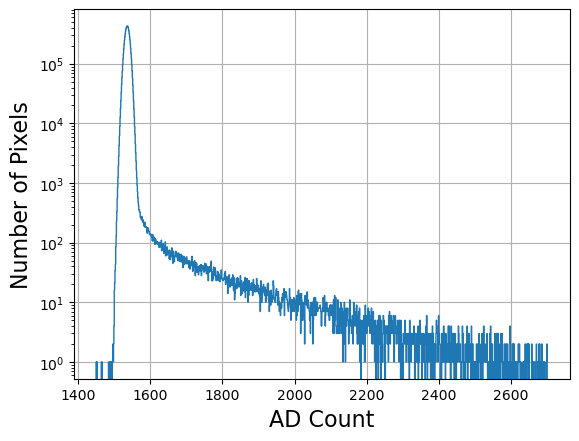

In [5]:
# get threshold values from averaged 0mW data
all_images = np.full((300, 512, 512), np.NaN)
folder_path = folder_path_day + '\\0116'
for count_b, filename in enumerate(os.listdir(folder_path)):
    file_path = os.path.join(folder_path, filename)
    with h5py.File(file_path, 'r') as file:
        image_data = file['images/camera/fluorescence/frame'][:]
        all_images[count_b, :, :] = image_data

background_counts = all_images.ravel()

#Plot histogram for total 300 pics
plt.figure(3)
background_bins=plt.hist(background_counts,bins=np.arange(1450.5,2700.5, 1),log=True, histtype='step')
counts=background_bins[1][:-1]+.5
counts=counts.astype(int)

plt.grid()
plt.xlabel('AD Count', fontsize=16)
plt.ylabel('Number of Pixels', fontsize=16)

# # Plot error rate 
# plt.figure(4)
# plt.hist(background_counts,bins=np.arange(1450.5,2700.5),log=True, histtype='step', density = True, cumulative=-1)
# plt.xlabel('Threshold', fontsize=16)
# plt.ylabel('Error rate', fontsize=16)
# plt.show()

[9.63986293e-02 7.00000000e+00 1.53700000e+03]
[69, 99, 1513, 1557, 1480, 1900]
fit region: AD count =  1520 to  1549
Fit Converged
Converged with chi-squared 342.7952049701789
Number of degrees of freedom, dof = 27
Reduced chi-squared 12.696118702599218
Inital guess values:
  p0 = [0.09639862933298098, 7, 1537]
Best fit values:
  pf = [0.09939867522859547, 7.243668957010237, 1536.5179330951062]
Uncertainties in the best fit values:
  pferr = [3.75324869020164e-05, 0.0028558667257754166, 0.003071998635739829]
5 sigma threshold is 1572.7362778801573 with uncertainty 0.017351332264616912


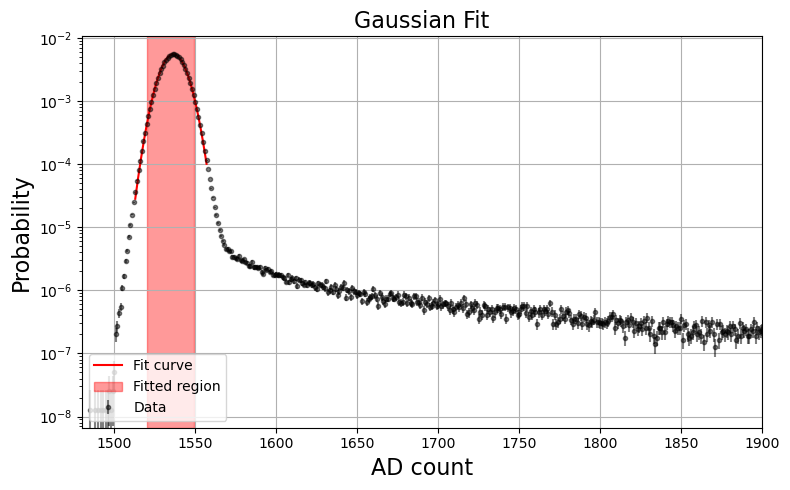

In [6]:
# Get threshold
probability=background_bins[0]/len(background_counts) #Assuming each pixel get 0 or 1 photon -SF
probability_uncertainty=(.1+background_bins[0])**.5/len(background_counts) #Shot noise? -SF
peak_probability = np.max(probability)
peak_index = np.argmax(probability)
peak=counts[peak_index]

#Select x region where you want to fit the gaussian: this can be arbirary
Start_gaussian=1520
End_gaussian=1550

index_Start = np.abs(counts - Start_gaussian).argmin() #closest_index_to_Start_gaussian
index_End = np.abs(counts - End_gaussian).argmin() #closest_index_to_End_gaussian

# Select x region where you want to plot the fitted gaussian: this must include the above region
Plotfit_min = counts[index_Start] -7
Plotfit_max = counts[index_End] +7

# Select x region where you want to plot the data: this must include the above region
Dataplot_min = 1480
Dataplot_max = 1900

# Guess the std of your Gaussian fit!
guess_std=7

print(np.array([peak_probability * (guess_std*np.sqrt(2*np.pi)), guess_std, peak]))
# Now apply the Gaussian fit to your histogram and plot...
plotting_values = [index_Start, index_End, Plotfit_min, Plotfit_max, Dataplot_min, Dataplot_max]
print(plotting_values)
pf=gaussian_fit(counts,probability,probability_uncertainty, [peak_probability * (guess_std*np.sqrt(2*np.pi)), guess_std, peak], plotting_values,show_details=True) #Note that peak value of normal distribution with std=X is 1/(X*sqrt(2pi))
 

# Photon counting LIF with threshold count=1573

In [138]:
seq = 114 #sequence number

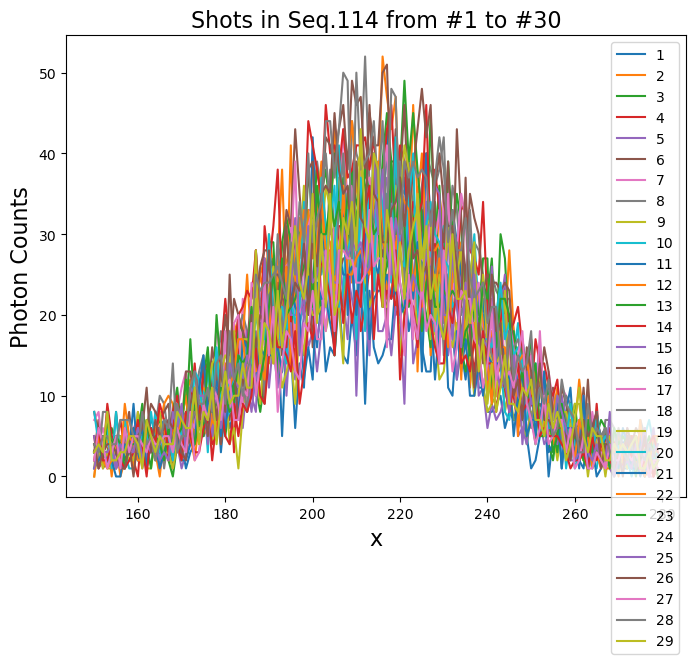

total # of photons =  55213
total_counts= 29
average # of photons =  1903.896551724138
std =  359.91907273199087


In [150]:
count_b_start=1
count_b_end=30

folder_path = folder_path_day + '\\%.4i'%seq
sum_array=[] #total photons
fig = plt.figure(20, figsize=(8,6))
# total_counts=0
# get x-cross section for every shot in the sequence
for count_b, filename in enumerate(os.listdir(folder_path)): 
    file_path = os.path.join(folder_path, filename)
    if count_b<=count_b_end and count_b>=count_b_start:
        # if count_b==29:
        #     print("skipping count_b=", count_b)
        #     continue
    # if np.any(np.array([4,6,8,9,12,14,15, 17, 18])==count_b):
        with h5py.File(file_path, 'r') as file:
            image_data = file['images/camera/fluorescence/frame'][:]
            image_data[image_data<1573]=0
            cross_section_x = np.count_nonzero(image_data, axis=0)
            
            # plt.plot(np.arange(512),cross_section_x, label=count_b)
            # sum_array.append(np.sum(cross_section_x))
            plt.plot(np.arange(150,280,1),cross_section_x[150:280], label=count_b)
            sum_array.append(np.sum(cross_section_x[150:280]))
            # total_counts+=1


# plt.ylim([1528,1660])
plt.xlabel('x', fontsize=16)
# plt.title('Shots in Seq.7', fontsize=16)
plt.title('Shots in Seq.%i from #%i to #%i' %(seq, count_b_start, count_b_end), fontsize=16)
plt.ylabel('Photon Counts', fontsize=16)
plt.legend()
plt.show()

print("total # of photons = ", np.sum(sum_array))
# print("total_counts=", total_counts)
print("total_counts=", len(sum_array))
print("average # of photons = ", np.mean(sum_array))
print("std = ", np.std(sum_array, ddof=1))


In [34]:
# frequencies=np.arange(348.661109, 348.661329, 0.000020)*1E6 - 35 - 348661174 
# print(frequencies)
# photons=np.array([12822, 15151, 22935, 22992, 35053, 63060, 125449, 59053, 49176, 55341, 30260, 18562, 13055])
# plt.figure(figsize=(8,4))
# plt.plot(frequencies, photons, 'bo-')
# plt.title("Single Frequency Scan", fontsize=16)
# plt.xlabel("Frequency [MHz] Offset from 348661174 MHz", fontsize=16)
# plt.ylabel("LIF Photons", fontsize=16)
# plt.grid()

2025-08-07_0049_BaF_Fluorescence_16.h5


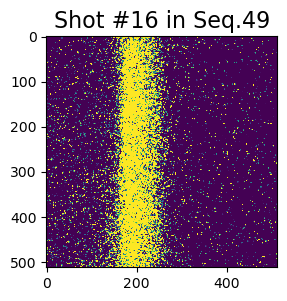

In [66]:
##Show FLuorescence plots of a shot
for n in np.array([16]):
    shot_number =n #Choose shot number you want to see
    folder_path = folder_path_day + r'/%.4i'%seq
    for count_b, filename in enumerate(os.listdir(folder_path)):
          if count_b==shot_number: 
              file_path = os.path.join(folder_path, filename)
              print(filename)
              with h5py.File(file_path, 'r') as file:
                image_data = file['images/camera/fluorescence/frame'][:]
                analog_data=file['data/traces/Absorption'][:]
                # print(analog_data)
                times, values = zip(*analog_data)
                # Convert to NumPy arrays if needed
                times = np.array(times)
                values = np.array(values)
                tYAG=2e-3 # Hardcoded for now...
                fig = plt.figure(2, figsize=(3, 3))
                plt.imshow(image_data, vmin = 1550, vmax = 1600)
                plt.title('Shot #%i in Seq.%i' % (shot_number, seq), fontsize=16)
                plt.show()

# Let's plot

[-1.00000000e+02 -8.00000000e+01 -6.00000000e+01 -4.00000000e+01
 -1.99999999e+01  5.96046448e-08  2.00000001e+01  4.00000001e+01
  6.00000001e+01  8.00000001e+01  1.00000000e+02  1.20000000e+02]


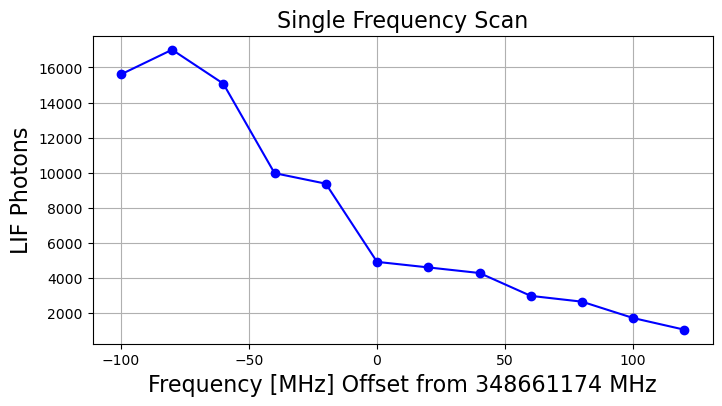

In [335]:
frequencies=np.arange(348.661109, 348.661329, 0.000020)*1E6 - 35 - 348661174 
print(frequencies)
photons=np.array([15604, 17014, 15078, 9973, 9373, 4913, 4596, 4277, 2973, 2642, 1708, 1042])
plt.figure(figsize=(8,4))
plt.plot(frequencies, photons, 'bo-')
plt.title("Single Frequency Scan", fontsize=16)
plt.xlabel("Frequency [MHz] Offset from 348661174 MHz", fontsize=16)
plt.ylabel("LIF Photons", fontsize=16)
plt.grid()

[-100  -90  -80  -70  -60  -50  -40  -30  -20  -10    0   10   20   30
   40   50   60   70   80   90  100  110  120  130]


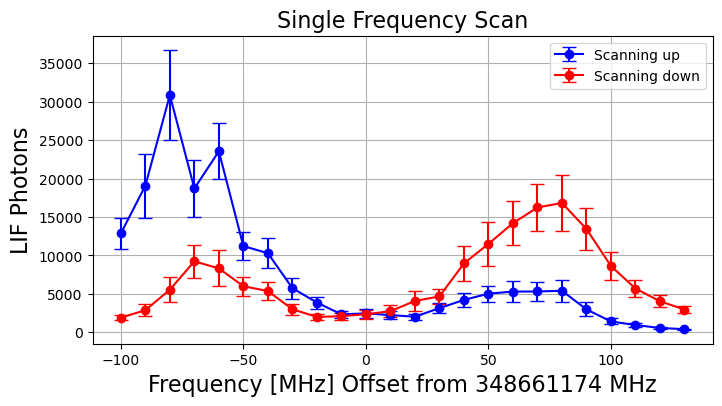

In [152]:
frequencies=np.arange(348661109, 348661349, 10) - 35 - 348661174 
print(frequencies)

photons1=np.array([12852, 19067, 30867, 18710, 23549, 11210, 10289, 5737, 3861, 2327, 2449, 2230, 2016, 3136, 4202, 5017, 5291, 5301, 5394, 2977, 1400, 937, 553, 402])
sem1=np.array([357, 758, 1077, 671, 666, 339, 356, 250, 142, 88, 113, 89, 66, 120, 167, 190, 248, 221, 258, 165, 72, 37, 16, 14])*29/np.sqrt(28)
photons2=np.array([2953, 4029, 5689, 8616, 13443, 16818, 16238, 14193, 11498, 8951, 4663, 4068, 2734, 2337, 2085, 1989, 2990, 5362, 5986, 8313, 9224, 5536, 2860, 1904])
sem2=np.array([94, 142, 198, 328, 489, 662, 566, 522, 526, 426, 177, 245, 137, 111, 87, 76, 130, 224, 221, 425, 387, 296, 138, 67])*29/np.sqrt(28)
plt.figure(figsize=(8,4))
plt.errorbar(frequencies, photons1, yerr=sem1, fmt='bo-', label="Scanning up", capsize=5)
plt.errorbar(frequencies[::-1], photons2, yerr=sem2, fmt='ro-', label="Scanning down", capsize=5)
plt.title("Single Frequency Scan", fontsize=16)
plt.xlabel("Frequency [MHz] Offset from 348661174 MHz", fontsize=16)
plt.ylabel("LIF Photons", fontsize=16)
plt.grid()
plt.legend()

[0.  1.2 2.4 3.6 4.8 6.  7.2 8.4 9.6]


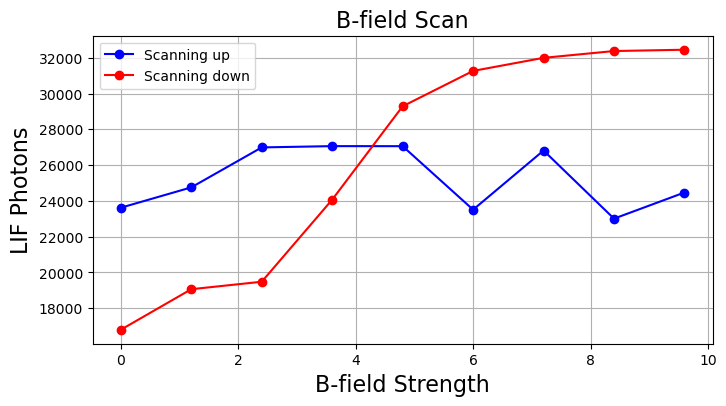

In [346]:
fields=np.linspace(0, 9.6, num=9)
print(fields)
photons1=np.array([23620, 24757, 26991, 27063, 27060, 23510, 26817, 23010, 24470])
photons2=np.array([32452, 32378, 31998, 31267, 29290, 24071, 19482, 19065, 16800])
plt.figure(figsize=(8,4))
plt.plot(fields, photons1, 'bo-', label="Scanning up")
plt.plot(fields[::-1], photons2, 'ro-', label="Scanning down")
plt.title("B-field Scan", fontsize=16)
plt.xlabel("B-field Strength", fontsize=16)
plt.ylabel("LIF Photons", fontsize=16)
plt.grid()
plt.legend()